In [1]:
!pip install quantities --quiet
!pip install neo --quiet
!pip install elephant --quiet

     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 2.1MB 4.7MB/s 
     |████████████████████████████████| 2.1MB 5.3MB/s 


In [3]:
import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [6]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# Data description

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

# Spike Labeling

* We are doing spike labeling based on: [(Loren M. Frank, Emery N. Brown, and Matthew A. Wilson, 2001)](https://journals.physiology.org/doi/full/10.1152/jn.2001.86.4.2029) in which putativa excitatory neurons (PE) had >0.4 trough to peak time $ms$ and <5 $Hz$ mean firing rate, in the other hand putative inhibitory neurons had <0.4 trough to peak time and >5 $Hz$ mean firing rate.



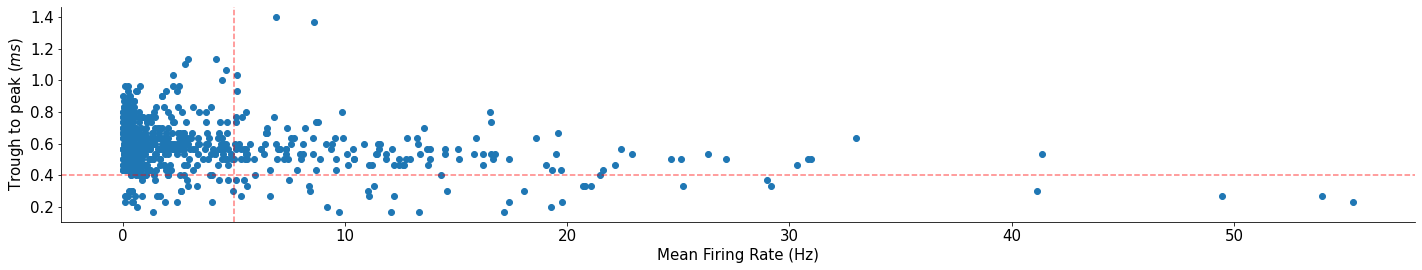

In [9]:
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms
plt.scatter(mean_firing,t_t_peak)
plt.axhline(y=0.4,ls = '--', alpha = 0.5, c = 'r')
plt.axvline(x=5,ls = '--', alpha = 0.5, c = 'r')
plt.ylabel('Trough to peak ($ms$)')
plt.xlabel('Mean Firing Rate (Hz)');


Next, we create a dataframe, and construct a column replacing brain regions per its area:

In [10]:
labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

Labeling according to conditions:

* Default condition is *other*

In [11]:
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

In [12]:
labeling_df.head()

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory


In [13]:
import plotly.express as px

px.scatter(x="Mean Firing Rate", y ="Trough to peak", color = "Cell Type", data_frame = labeling_df)

In [15]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
# 
Selection = (labeling_df['Area']=='Thalamus') & (labeling_df['Cell Type']=='Excitatory')
spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
spikes.shape

(340, 250)

In [16]:
mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
time = binsize * np.arange(dat['spks'].shape[-1])

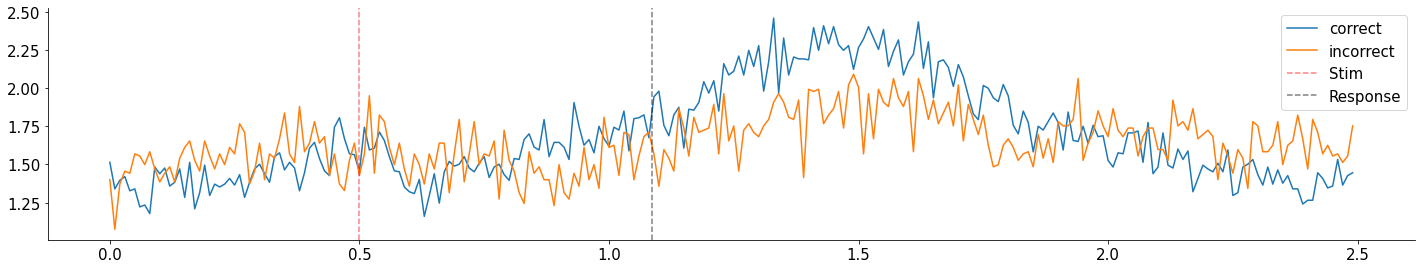

In [35]:
plt.plot(time, mean_fr_e,label='correct')
plt.plot(time, mean_fr_i,label='incorrect')
plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')

plt.legend()

# --- DEAD END ---
# Raster plot

In [36]:
spikes= dat2['ss']

In [42]:
plt.figure(figsize=(9,5))
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Excitatory')][:,3]);
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Other')][:,3],color='k');
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Inhibitory')][:,3],colors = 'r');
plt.yticks([]);


SyntaxError: ignored

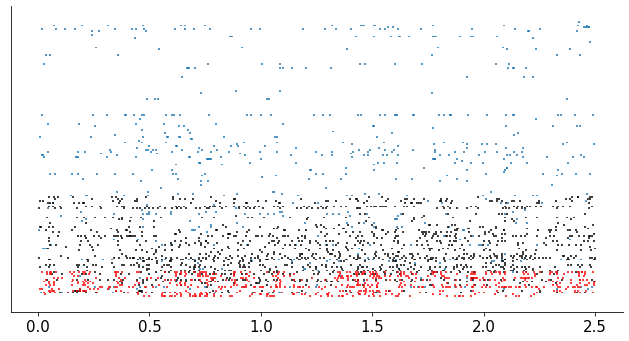

In [20]:
plt.figure(figsize=(9,5))
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Excitatory')][:,3]);
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Other')][:,3],color='k');
plt.eventplot(spikes[(labeling_df['Area']=='Hippocampus') & (labeling_df['Cell Type']=='Inhibitory')][:,3],colors = 'r');
plt.yticks([]);

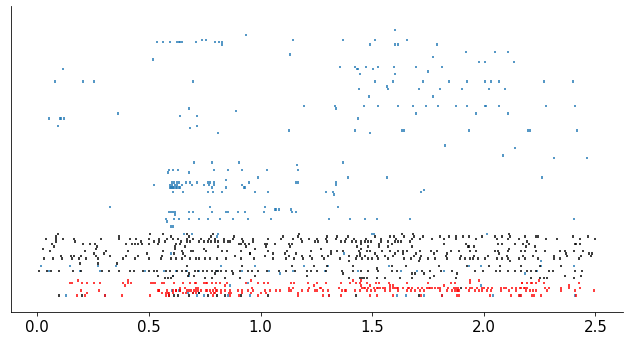

In [30]:
plt.figure(figsize=(9,5))
plt.eventplot(spikes[(labeling_df['Area']=='Visual Ctx') & (labeling_df['Cell Type']=='Excitatory')][:,3]);
plt.eventplot(spikes[(labeling_df['Area']=='Visual Ctx') & (labeling_df['Cell Type']=='Other')][:,3],color='k');
plt.eventplot(spikes[(labeling_df['Area']=='Visual Ctx') & (labeling_df['Cell Type']=='Inhibitory')][:,3],colors = 'r');
plt.yticks([]);

# Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [32]:
  bin_spk_hip = dat['spks'][(labeling_df['Area']=='Visual Ctx')]
  bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)
  norm_spike_train = bin_spk_hip.mean(axis=2)
  X = norm_spike_train
  bin_spk_hip.shape

(340, 145, 250)

In [33]:
def LogReg(area,target):
  bin_spk_hip = dat['spks'][(labeling_df['Area']==area)]
  bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)
  norm_spike_train = bin_spk_hip.mean(axis=2)
  X = norm_spike_train
  y = target
  model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
  Log_model=model.fit(X,y)
  accuracies = cross_val_score(model,X,y,cv=10)
  return Log_model, accuracies

In [34]:
left = np.where(dat['response']!=1,0,1)
right = np.where(dat['response']!=-1,0,-1)*-1

In [35]:
only_left = np.where((dat['contrast_left']>0)&(dat['contrast_right']==0),1,0)
np.sum(only_left == 1)

59

In [36]:
only_right = np.where((dat['contrast_right']>0)&(dat['contrast_left']==0),1,0)
np.sum(only_right == 1)

65

In [37]:
higher_contrast_right = np.where(dat['contrast_right']==1,1,0)
higher_contrast_left = np.where(dat['contrast_left']==1,1,0)
reward = np.where(dat['feedback_type']==1,1,0)

In [38]:
from scipy.ndimage.interpolation import shift

In [39]:
model, accuracies = LogReg('Visual Ctx',only_left)

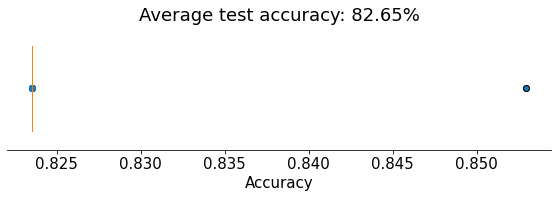

In [40]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(10))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [41]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()

In [42]:
models = {
  "$L_1$ ": model
}

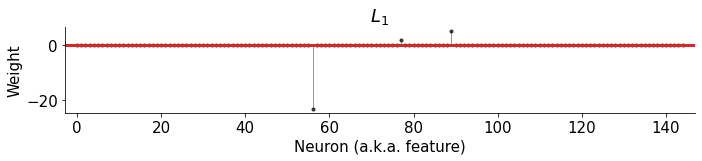

In [43]:
plot_weights(models)

# PCA

In [44]:
bin_spk_hip = dat['spks'][(labeling_df['Area']=='Hippocampus')]
bin_spk_hip = np.moveaxis(bin_spk_hip,1,0)

In [45]:
ravel_thing = np.ravel(bin_spk_hip).reshape(220,-1)
ravel_thing.shape

(220, 85000)

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCA_fit = pca.fit(ravel_thing)

In [48]:
dim_1 = PCA_fit.components_[0].reshape(340,250)
dim_2 = PCA_fit.components_[1].reshape(340,250)

In [49]:
dim_1.shape

(340, 250)

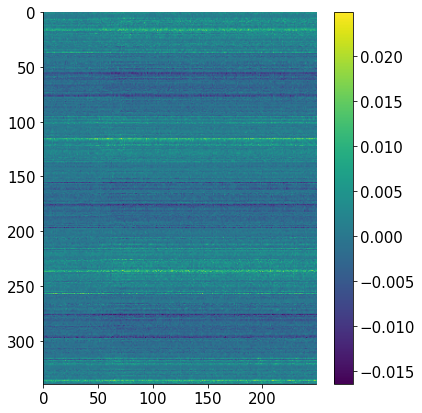

In [50]:
plt.figure(figsize=(6,6))
plt.imshow(dim_1)
plt.colorbar()

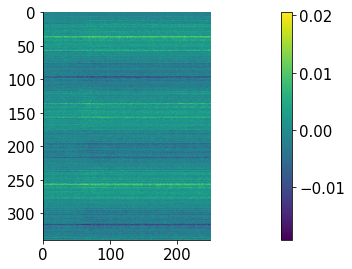

In [51]:
plt.imshow(dim_2)
plt.colorbar()

In [52]:
X_trans = PCA_fit.transform(ravel_thing)

In [53]:
Score_df = pd.DataFrame(
    {
        'Score 1': X_trans[:,0],
        'Score 2': X_trans[:,1],
    }
)

In [54]:
hip = labeling_df[labeling_df['Area']=='Hippocampus']
hip.shape

(220, 5)

In [55]:
hip['Score 1'] = X_trans[:,0]
hip['Score 2'] = X_trans[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
hip

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type,Score 1,Score 2
3,0.190588,0.566667,DG,Hippocampus,Excitatory,1.275646,-10.696713
6,0.141176,0.600000,SUB,Hippocampus,Excitatory,-2.805618,-5.593720
7,2.327059,0.733333,DG,Hippocampus,Excitatory,-9.086812,-10.188344
10,0.048235,0.566667,SUB,Hippocampus,Excitatory,-9.749716,1.683306
11,0.124706,0.266667,DG,Hippocampus,Other,-11.238723,4.026969
...,...,...,...,...,...,...,...
684,1.452941,0.766667,CA1,Hippocampus,Excitatory,-1.048889,10.126585
687,2.770588,0.666667,CA1,Hippocampus,Excitatory,5.781051,4.930523
688,5.150588,0.933333,CA1,Hippocampus,Other,14.875506,5.438964
690,0.352941,0.900000,CA1,Hippocampus,Excitatory,5.170643,-3.583914


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



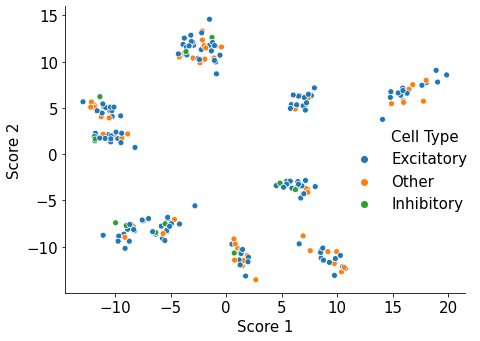

In [57]:
import seaborn as sns

sns.relplot(x='Score 1',y='Score 2', hue= 'Cell Type', data = hip)

# Same PCA analysis as above, for thalamus:-

In [71]:
bin_spk_thal = dat['spks'][(labeling_df['Area']=='Thalamus')]
bin_spk_thal = np.moveaxis(bin_spk_thal,1,0)
norm_spike_train = bin_spk_thal.mean(axis=2)
X = norm_spike_train
bin_spk_thal.shape


(340, 155, 250)

In [72]:
ravel_thing = np.ravel(bin_spk_thal).reshape(155,-1)
ravel_thing.shape

(155, 85000)

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCA_fit = pca.fit(ravel_thing)

In [75]:
dim_1 = PCA_fit.components_[0].reshape(340,250)
dim_2 = PCA_fit.components_[1].reshape(340,250)

In [76]:
dim_1.shape

(340, 250)

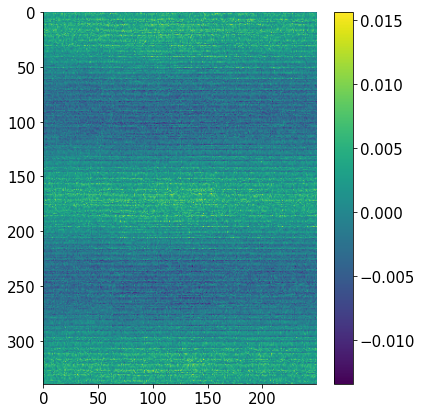

In [77]:
plt.figure(figsize=(6,6))
plt.imshow(dim_1)
plt.colorbar()

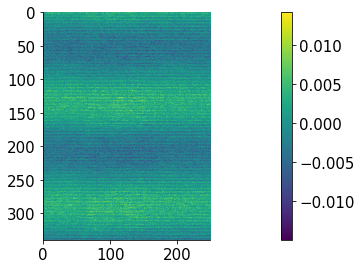

In [78]:
plt.imshow(dim_2)
plt.colorbar()

In [79]:
X_trans = PCA_fit.transform(ravel_thing)

In [80]:
Score_df = pd.DataFrame(
    {
        'Score 1': X_trans[:,0],
        'Score 2': X_trans[:,1],
    }
)

In [81]:
thal = labeling_df[labeling_df['Area']=='Thalamus']
thal.shape

(155, 5)

In [82]:
thal['Score 1'] = X_trans[:,0]
thal['Score 2'] = X_trans[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
thal

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type,Score 1,Score 2
45,2.960000,0.333333,LGd,Thalamus,Other,-9.289792,12.560208
62,1.680000,0.466667,LGd,Thalamus,Excitatory,-14.513192,-1.060036
71,0.137647,0.266667,LGd,Thalamus,Other,-4.889560,-15.127911
79,3.925882,0.400000,LGd,Thalamus,Other,19.183049,-12.946410
130,0.069412,0.466667,LGd,Thalamus,Excitatory,14.348614,12.986100
...,...,...,...,...,...,...,...
689,0.852941,0.500000,MD,Thalamus,Excitatory,-11.646374,9.308539
691,30.972941,0.500000,MD,Thalamus,Other,-12.265423,-4.733788
692,12.454118,0.500000,MD,Thalamus,Other,-1.484556,-11.080625
693,0.501176,0.566667,MD,Thalamus,Excitatory,16.665005,-5.362846


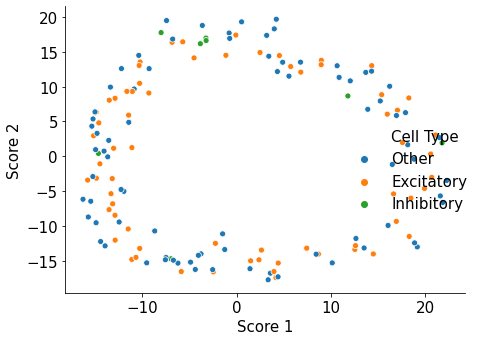

In [84]:
import seaborn as sns

sns.relplot(x='Score 1',y='Score 2', hue= 'Cell Type', data = thal)

# Same PCA analysis as above, for visual cortex:-

In [85]:
bin_spk_vis = dat['spks'][(labeling_df['Area']=='Visual Ctx')]
bin_spk_vis = np.moveaxis(bin_spk_vis,1,0)
norm_spike_train = bin_spk_vis.mean(axis=2)
X = norm_spike_train
bin_spk_vis.shape

(340, 145, 250)

In [103]:
ravel_thing = np.ravel(bin_spk_vis).reshape(145,-1)
ravel_thing.shape

(145, 85000)

In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PCA_fit = pca.fit(ravel_thing)

In [89]:
dim_1 = PCA_fit.components_[0].reshape(340,250)
dim_2 = PCA_fit.components_[1].reshape(340,250)

In [90]:
dim_1.shape

(340, 250)

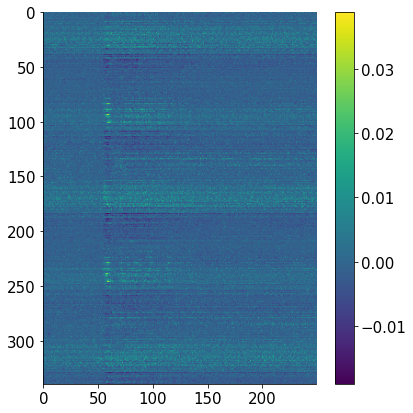

In [91]:
plt.figure(figsize=(6,6))
plt.imshow(dim_1)
plt.colorbar()

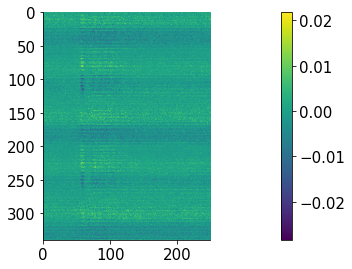

In [92]:
plt.imshow(dim_2)
plt.colorbar()

In [93]:
X_trans = PCA_fit.transform(ravel_thing)

In [94]:
Score_df = pd.DataFrame(
    {
        'Score 1': X_trans[:,0],
        'Score 2': X_trans[:,1],
    }
)

In [95]:
vis = labeling_df[labeling_df['Area']=='Visual Ctx']
vis.shape

(145, 5)

In [96]:
vis['Score 1'] = X_trans[:,0]
vis['Score 2'] = X_trans[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
vis

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type,Score 1,Score 2
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory,-1.328293,1.131381
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory,-4.475349,1.393917
2,5.368235,0.766667,VISp,Visual Ctx,Other,14.822865,-3.675504
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory,-5.636551,-0.882571
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory,-4.806406,0.725783
...,...,...,...,...,...,...,...
683,2.050588,0.633333,VISam,Visual Ctx,Excitatory,2.602311,5.978491
685,0.997647,0.666667,VISam,Visual Ctx,Excitatory,-2.053192,-9.792742
686,1.084706,0.566667,VISam,Visual Ctx,Excitatory,-2.725853,1.703870
694,0.016471,0.666667,VISam,Visual Ctx,Excitatory,-1.513971,7.090009


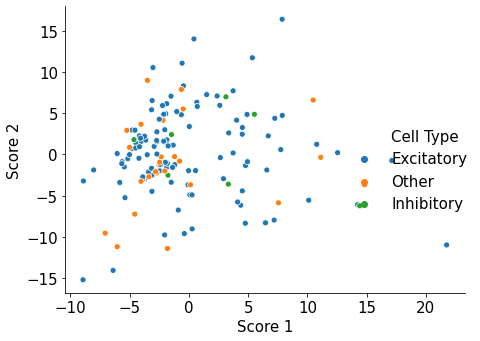

In [99]:
import seaborn as sns

sns.relplot(x='Score 1',y='Score 2', hue= 'Cell Type', data = vis)